<a href="https://colab.research.google.com/github/julianoctvaz/PNL/blob/main/MainPLnTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import pathlib
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tfds.disable_progress_bar()


Import matplotlib and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Download and explore the dataset

In [ ]:
data_url = 'https://github.com/julianoctvaz/PNL/blob/main/sample-data.tar.gz?raw=true'
dataset_dir = tf.keras.utils.get_file(
    origin=data_url,
    untar=True,
    # cache_dir='sample_data',
    # cache_subdir='',
    fname='temp')

dataset_dir = pathlib.Path(dataset_dir).parent

In [ ]:
list(dataset_dir.iterdir())

[PosixPath('/root/.keras/datasets/temp.tar.gz'),
 PosixPath('/root/.keras/datasets/test'),
 PosixPath('/root/.keras/datasets/train')]

In [ ]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/root/.keras/datasets/train/getForecastWeather'),
 PosixPath('/root/.keras/datasets/train/getWeather')]

In [ ]:
sample_file = train_dir/'getWeather/1.txt'
with open(sample_file) as f:
  print(f.read())

Will it be sunny one hundred thirty five days from now in Monterey Bay National Marine Sanctuary


In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 1396 files belonging to 2 classes.
Using 1117 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b"What's the forecast for Alley. Canada?"
Label: 0
Question:  b'what is the forecast for Tschetter Colony on Ascension Day in Oregon'
Label: 0
Question:  b'Will the weather in Falcon Heights call for rain?'
Label: 1
Question:  b'Will there be a lot of sun in Dry Prong Somalia at 5 pm'
Label: 1
Question:  b"What's the weather 1 minute from now in Mount Nimba Strict Nature Reserve"
Label: 1
Question:  b'Will it be warm neighboring here in Whitehouse?'
Label: 1
Question:  b'Is it warm faraway in Niger?'
Label: 1
Question:  b'What will the weather be in Michigan?'
Label: 1
Question:  b'Is there forecast to be snow in GU this summer?'
Label: 0
Question:  b'What is the weather close to Somesville on mon.'
Label: 1


In [ ]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to getForecastWeather
Label 1 corresponds to getWeather


In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 1396 files belonging to 2 classes.
Using 279 files for validation.


In [ ]:
for text_batch, label_batch in raw_val_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'Where is Bernardsville?'
Label: 1
Question:  b'Can you tell me the weather forecast for six am in Grenada'
Label: 0
Question:  b'Weather for Oct. 16 in MO'
Label: 1
Question:  b'what is the Sri Lanka forecast for snow'
Label: 0
Question:  b"What's the weather forecast for Hooven, Lithuania on National Grandparents Day?"
Label: 0
Question:  b"What's the forecast for Wendell?"
Label: 0
Question:  b'Can you give me the forecast for 10:15 in Paraguay'
Label: 0
Question:  b'What is the forecast for Farmerville in Cape Verde'
Label: 0
Question:  b'Is there a snowstorm in the forecast for Saint Helena?'
Label: 0
Question:  b'Is it hot in Gold Beach, Bahrain? '
Label: 1


In [ ]:
test_dir = dataset_dir/'test'
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 597 files belonging to 2 classes.


# Create the text encoder

In [ ]:
VOCAB_SIZE = 500
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=500)
encoder.adapt(raw_train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'in', 'the', 'weather', 'be', 'is', 'will', 'it',
       'for', 'forecast', 'what', 'at', 'whats', 'on', 'to', 'now',
       'from', 'me', 'like'], dtype='<U13')

In [ ]:
encoded_example = encoder('forecast')[:3].numpy()
encoded_example

array([10])

# Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
sample_text = ('What is the weather in Florida');
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00091317]


In [ ]:
padding = "What " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00091317]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, None)              0         
_________________________________________________________________
embedding_114 (Embedding)    (None, None, 64)          32000     
_________________________________________________________________
bidirectional_229 (Bidirecti (None, 128)               66048     
_________________________________________________________________
dense_228 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                 65        
Total params: 106,369
Trainable params: 106,369
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 14s 114ms/step - loss: 0.6833 - accuracy: 0.2892 - val_loss: 0.6718 - val_accuracy: 0.2812
Epoch 2/8
35/35 [==============================] - 1s 36ms/step - loss: 0.6570 - accuracy: 0.2892 - val_loss: 0.6223 - val_accuracy: 0.2125
Epoch 3/8
35/35 [==============================] - 1s 36ms/step - loss: 0.6069 - accuracy: 0.4261 - val_loss: 0.5663 - val_accuracy: 0.7563
Epoch 4/8
35/35 [==============================] - 1s 36ms/step - loss: 0.5203 - accuracy: 0.8406 - val_loss: 0.4950 - val_accuracy: 0.8062
Epoch 5/8
35/35 [==============================] - 1s 36ms/step - loss: 0.4148 - accuracy: 0.8845 - val_loss: 0.3748 - val_accuracy: 0.9000
Epoch 6/8
35/35 [==============================] - 1s 36ms/step - loss: 0.3182 - accuracy: 0.9329 - val_loss: 0.3295 - val_accuracy: 0.9125
Epoch 7/8
35/35 [==============================] - 1s 37ms/step - loss: 0.2639 - accuracy: 0.9427 - val_loss: 0.2200 - val_accuracy: 0.9375
Epoch 8/8
35/35 [=

In [ ]:
model_one_layer_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.55892205]]


In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


19/19 [==============================] - 0s 11ms/step - loss: 0.1816 - accuracy: 0.9531
Test Loss: 0.1816306710243225
Test Accuracy: 0.9530988335609436


(0.0, 0.706918865442276)

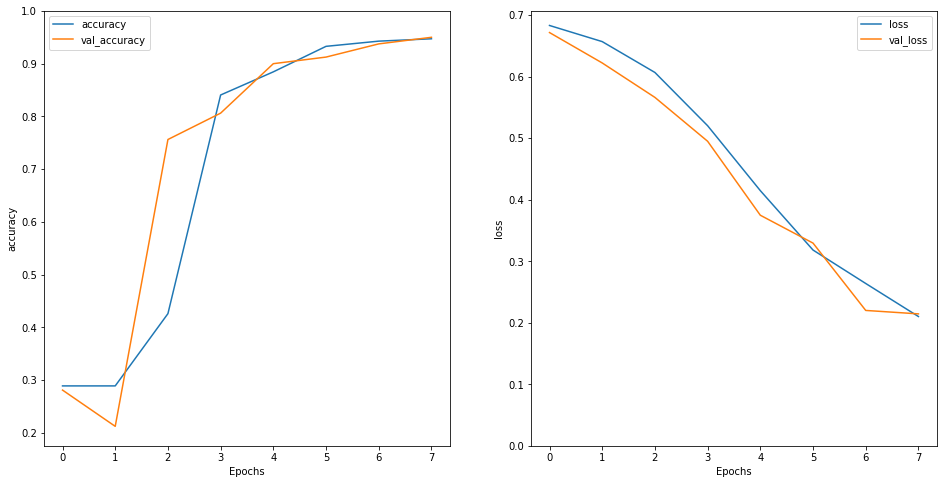

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Stack two or more LSTM layers

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 29s 209ms/step - loss: 0.6853 - accuracy: 0.2892 - val_loss: 0.6717 - val_accuracy: 0.2438
Epoch 2/8
35/35 [==============================] - 2s 59ms/step - loss: 0.6592 - accuracy: 0.2892 - val_loss: 0.6418 - val_accuracy: 0.3000
Epoch 3/8
35/35 [==============================] - 2s 57ms/step - loss: 0.6026 - accuracy: 0.5076 - val_loss: 0.5569 - val_accuracy: 0.7063
Epoch 4/8
35/35 [==============================] - 2s 59ms/step - loss: 0.5194 - accuracy: 0.7887 - val_loss: 0.4719 - val_accuracy: 0.7937
Epoch 5/8
35/35 [==============================] - 2s 58ms/step - loss: 0.4063 - accuracy: 0.8863 - val_loss: 0.3321 - val_accuracy: 0.9000
Epoch 6/8
35/35 [==============================] - 2s 58ms/step - loss: 0.3166 - accuracy: 0.9275 - val_loss: 0.2448 - val_accuracy: 0.9375
Epoch 7/8
35/35 [==============================] - 2s 58ms/step - loss: 0.2576 - accuracy: 0.9436 - val_loss: 0.2557 - val_accuracy: 0.9375
Epoch 8/8
35/35 [=

In [ ]:
model.summary()

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, None)              0         
_________________________________________________________________
embedding_115 (Embedding)    (None, None, 64)          32000     
_________________________________________________________________
bidirectional_230 (Bidirecti (None, None, 128)         66048     
_________________________________________________________________
bidirectional_231 (Bidirecti (None, 64)                41216     
_________________________________________________________________
dense_230 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_96 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 1)              

In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

19/19 [==============================] - 0s 16ms/step - loss: 0.1547 - accuracy: 0.9665


In [ ]:
relu_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.7935788]]


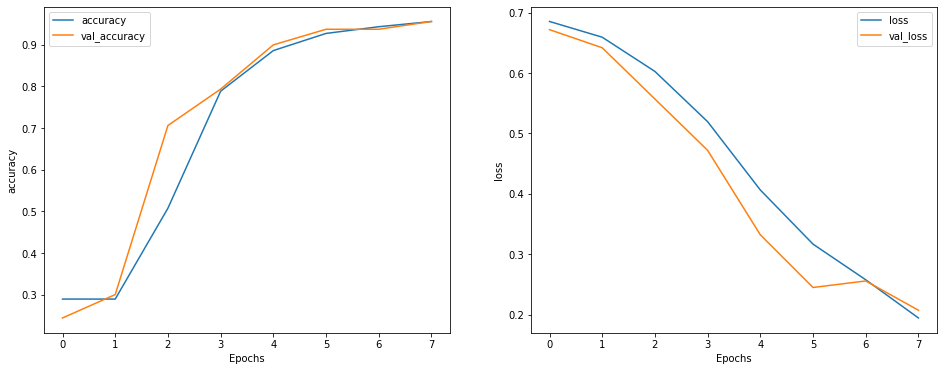

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using softmax activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 27s 217ms/step - loss: 0.6932 - accuracy: 0.2892 - val_loss: 0.6926 - val_accuracy: 0.2625
Epoch 2/8
35/35 [==============================] - 2s 62ms/step - loss: 0.6918 - accuracy: 0.2892 - val_loss: 0.6899 - val_accuracy: 0.2438
Epoch 3/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6885 - accuracy: 0.2892 - val_loss: 0.6857 - val_accuracy: 0.2688
Epoch 4/8
35/35 [==============================] - 2s 59ms/step - loss: 0.6804 - accuracy: 0.2892 - val_loss: 0.6740 - val_accuracy: 0.3063
Epoch 5/8
35/35 [==============================] - 2s 60ms/step - loss: 0.6630 - accuracy: 0.2892 - val_loss: 0.6533 - val_accuracy: 0.2750
Epoch 6/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6496 - accuracy: 0.2892 - val_loss: 0.6405 - val_accuracy: 0.2688
Epoch 7/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6353 - accuracy: 0.2919 - val_loss: 0.6260 - val_accuracy: 0.2750
Epoch 8/8
35/35 [=

In [ ]:
model.summary()

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_17 (TextV (None, None)              0         
_________________________________________________________________
embedding_116 (Embedding)    (None, None, 64)          32000     
_________________________________________________________________
bidirectional_232 (Bidirecti (None, None, 128)         66048     
_________________________________________________________________
bidirectional_233 (Bidirecti (None, 64)                41216     
_________________________________________________________________
dense_232 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_97 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 1)              

In [ ]:
softmax_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.11894852]]


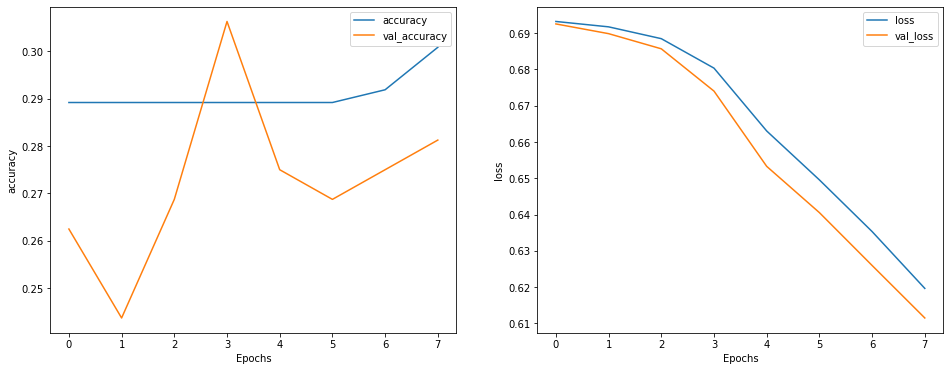

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using sigmoid activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 30s 209ms/step - loss: 0.7253 - accuracy: 0.3975 - val_loss: 0.6694 - val_accuracy: 0.2875
Epoch 2/8
35/35 [==============================] - 2s 58ms/step - loss: 0.7200 - accuracy: 0.3993 - val_loss: 0.6385 - val_accuracy: 0.2812
Epoch 3/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6633 - accuracy: 0.4933 - val_loss: 0.5721 - val_accuracy: 0.7625
Epoch 4/8
35/35 [==============================] - 2s 58ms/step - loss: 0.5830 - accuracy: 0.6374 - val_loss: 0.4704 - val_accuracy: 0.8000
Epoch 5/8
35/35 [==============================] - 2s 58ms/step - loss: 0.4905 - accuracy: 0.7592 - val_loss: 0.3450 - val_accuracy: 0.9438
Epoch 6/8
35/35 [==============================] - 2s 59ms/step - loss: 0.3581 - accuracy: 0.8630 - val_loss: 0.2848 - val_accuracy: 0.9375
Epoch 7/8
35/35 [==============================] - 2s 57ms/step - loss: 0.2926 - accuracy: 0.9015 - val_loss: 0.2376 - val_accuracy: 0.9438
Epoch 8/8
35/35 [=

In [ ]:
sigmoid_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.0165473]]


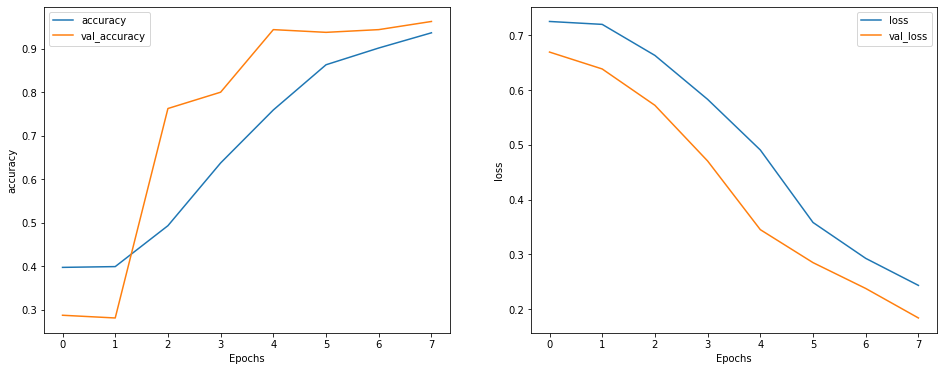

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using tanh activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 28s 200ms/step - loss: 0.6789 - accuracy: 0.2892 - val_loss: 0.6542 - val_accuracy: 0.2250
Epoch 2/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6380 - accuracy: 0.3115 - val_loss: 0.5956 - val_accuracy: 0.4187
Epoch 3/8
35/35 [==============================] - 2s 57ms/step - loss: 0.5613 - accuracy: 0.7287 - val_loss: 0.5293 - val_accuracy: 0.7563
Epoch 4/8
35/35 [==============================] - 2s 57ms/step - loss: 0.4644 - accuracy: 0.8380 - val_loss: 0.3490 - val_accuracy: 0.9250
Epoch 5/8
35/35 [==============================] - 2s 57ms/step - loss: 0.3133 - accuracy: 0.8970 - val_loss: 0.2624 - val_accuracy: 0.8875
Epoch 6/8
35/35 [==============================] - 2s 60ms/step - loss: 0.2022 - accuracy: 0.9203 - val_loss: 0.1571 - val_accuracy: 0.9375
Epoch 7/8
35/35 [==============================] - 2s 58ms/step - loss: 0.1346 - accuracy: 0.9588 - val_loss: 0.0677 - val_accuracy: 0.9875
Epoch 8/8
35/35 [=

In [ ]:
tanh_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.5599916]]


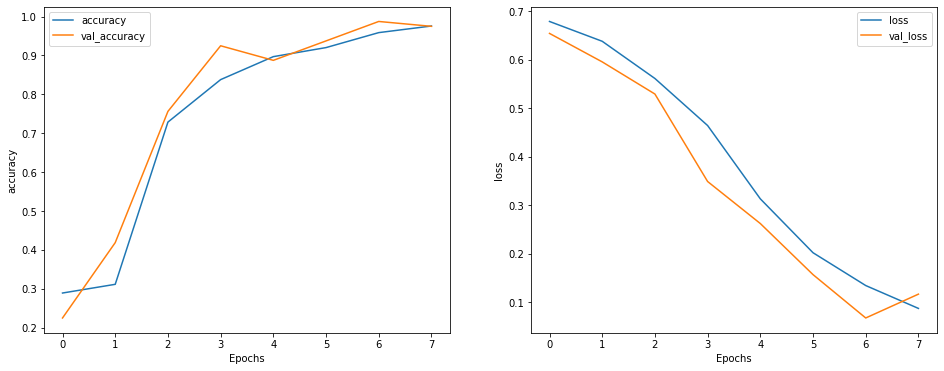

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using softplus activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='softplus'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 29s 221ms/step - loss: 1.0938 - accuracy: 0.3303 - val_loss: 0.9449 - val_accuracy: 0.2937
Epoch 2/8
35/35 [==============================] - 2s 57ms/step - loss: 1.0227 - accuracy: 0.3411 - val_loss: 0.8404 - val_accuracy: 0.2688
Epoch 3/8
35/35 [==============================] - 2s 59ms/step - loss: 0.8597 - accuracy: 0.4020 - val_loss: 0.6158 - val_accuracy: 0.4750
Epoch 4/8
35/35 [==============================] - 2s 59ms/step - loss: 0.6304 - accuracy: 0.6097 - val_loss: 0.5123 - val_accuracy: 0.7312
Epoch 5/8
35/35 [==============================] - 2s 63ms/step - loss: 0.5597 - accuracy: 0.7037 - val_loss: 0.3964 - val_accuracy: 0.8250
Epoch 6/8
35/35 [==============================] - 2s 62ms/step - loss: 0.4135 - accuracy: 0.7932 - val_loss: 0.3260 - val_accuracy: 0.8750
Epoch 7/8
35/35 [==============================] - 2s 60ms/step - loss: 0.3057 - accuracy: 0.8612 - val_loss: 0.2341 - val_accuracy: 0.9062
Epoch 8/8
35/35 [=

In [ ]:
softplus_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.32220992]]


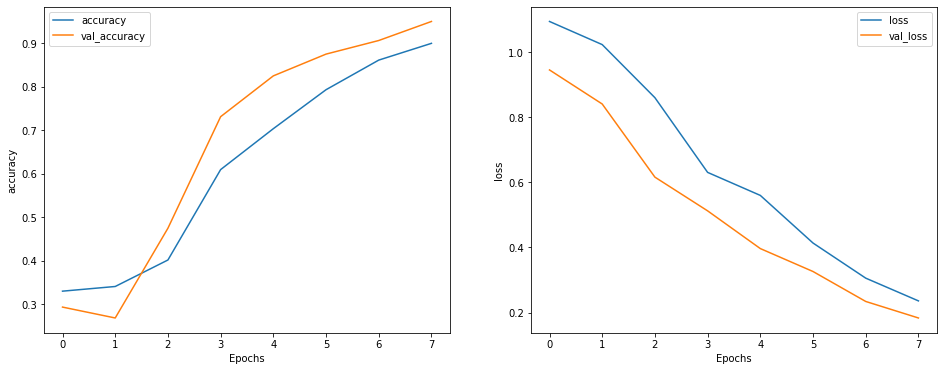

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using softsign activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='softsign'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 28s 205ms/step - loss: 0.6821 - accuracy: 0.2892 - val_loss: 0.6717 - val_accuracy: 0.3187
Epoch 2/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6467 - accuracy: 0.2981 - val_loss: 0.6096 - val_accuracy: 0.3375
Epoch 3/8
35/35 [==============================] - 2s 58ms/step - loss: 0.5755 - accuracy: 0.6544 - val_loss: 0.4840 - val_accuracy: 0.7812
Epoch 4/8
35/35 [==============================] - 2s 58ms/step - loss: 0.4665 - accuracy: 0.8496 - val_loss: 0.3560 - val_accuracy: 0.9375
Epoch 5/8
35/35 [==============================] - 2s 57ms/step - loss: 0.3027 - accuracy: 0.9042 - val_loss: 0.2389 - val_accuracy: 0.9062
Epoch 6/8
35/35 [==============================] - 2s 57ms/step - loss: 0.2058 - accuracy: 0.9346 - val_loss: 0.1888 - val_accuracy: 0.9500
Epoch 7/8
35/35 [==============================] - 2s 57ms/step - loss: 0.1449 - accuracy: 0.9561 - val_loss: 0.1508 - val_accuracy: 0.9625
Epoch 8/8
35/35 [=

In [ ]:
softsign_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.4495751]]


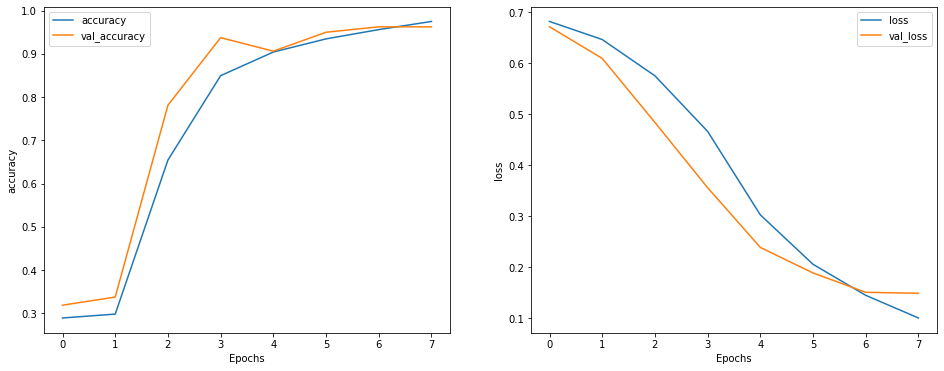

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using selu activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 26s 203ms/step - loss: 0.6738 - accuracy: 0.2892 - val_loss: 0.6492 - val_accuracy: 0.2688
Epoch 2/8
35/35 [==============================] - 2s 57ms/step - loss: 0.6233 - accuracy: 0.3903 - val_loss: 0.5553 - val_accuracy: 0.6875
Epoch 3/8
35/35 [==============================] - 2s 58ms/step - loss: 0.5435 - accuracy: 0.7825 - val_loss: 0.4587 - val_accuracy: 0.8125
Epoch 4/8
35/35 [==============================] - 2s 56ms/step - loss: 0.4332 - accuracy: 0.8639 - val_loss: 0.3645 - val_accuracy: 0.9062
Epoch 5/8
35/35 [==============================] - 2s 56ms/step - loss: 0.2749 - accuracy: 0.9024 - val_loss: 0.2033 - val_accuracy: 0.9187
Epoch 6/8
35/35 [==============================] - 2s 58ms/step - loss: 0.1851 - accuracy: 0.9293 - val_loss: 0.1486 - val_accuracy: 0.9375
Epoch 7/8
35/35 [==============================] - 2s 56ms/step - loss: 0.1285 - accuracy: 0.9552 - val_loss: 0.1064 - val_accuracy: 0.9750
Epoch 8/8
35/35 [=

In [ ]:
selu_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.463985]]


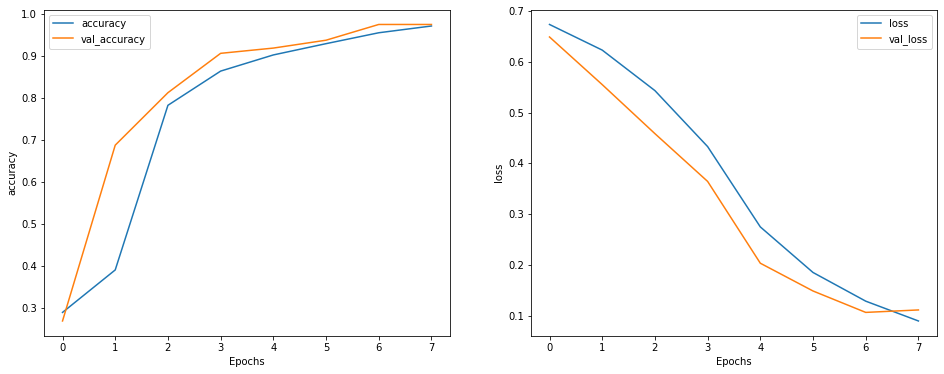

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using elu activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 29s 203ms/step - loss: 0.6813 - accuracy: 0.2892 - val_loss: 0.6591 - val_accuracy: 0.2188
Epoch 2/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6456 - accuracy: 0.2963 - val_loss: 0.6137 - val_accuracy: 0.3000
Epoch 3/8
35/35 [==============================] - 2s 59ms/step - loss: 0.5734 - accuracy: 0.6723 - val_loss: 0.5136 - val_accuracy: 0.7750
Epoch 4/8
35/35 [==============================] - 2s 60ms/step - loss: 0.4717 - accuracy: 0.8344 - val_loss: 0.3707 - val_accuracy: 0.9062
Epoch 5/8
35/35 [==============================] - 2s 60ms/step - loss: 0.3091 - accuracy: 0.9212 - val_loss: 0.2167 - val_accuracy: 0.9500
Epoch 6/8
35/35 [==============================] - 2s 61ms/step - loss: 0.1960 - accuracy: 0.9248 - val_loss: 0.1514 - val_accuracy: 0.9500
Epoch 7/8
35/35 [==============================] - 2s 61ms/step - loss: 0.1399 - accuracy: 0.9579 - val_loss: 0.1260 - val_accuracy: 0.9500
Epoch 8/8
35/35 [=

In [ ]:
elu_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.1266539]]


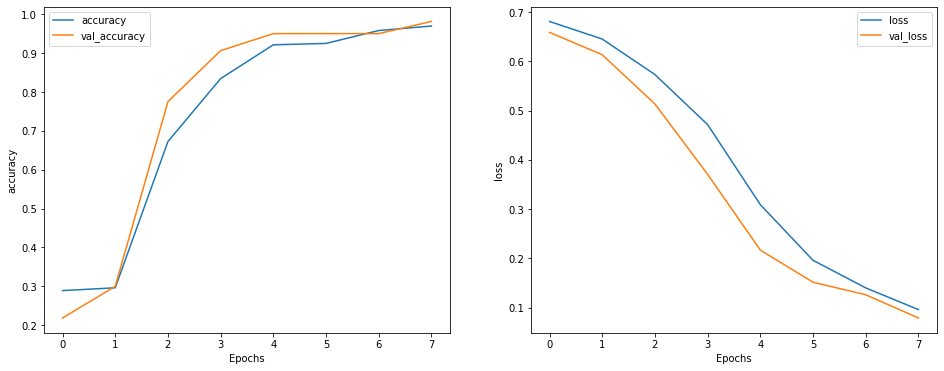

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Model using exponential activation

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='exponential'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(raw_train_ds, epochs=8,
                    validation_data=raw_val_ds,
                    validation_steps=5)

Epoch 1/8
35/35 [==============================] - 28s 204ms/step - loss: 0.7589 - accuracy: 0.5631 - val_loss: 0.5650 - val_accuracy: 0.7437
Epoch 2/8
35/35 [==============================] - 2s 61ms/step - loss: 0.7313 - accuracy: 0.5962 - val_loss: 0.5489 - val_accuracy: 0.7500
Epoch 3/8
35/35 [==============================] - 2s 59ms/step - loss: 0.7192 - accuracy: 0.5927 - val_loss: 0.5257 - val_accuracy: 0.7375
Epoch 4/8
35/35 [==============================] - 2s 58ms/step - loss: 0.6731 - accuracy: 0.6186 - val_loss: 0.3888 - val_accuracy: 0.8875
Epoch 5/8
35/35 [==============================] - 2s 60ms/step - loss: 0.4427 - accuracy: 0.7717 - val_loss: 0.2215 - val_accuracy: 0.9187
Epoch 6/8
35/35 [==============================] - 2s 59ms/step - loss: 0.2811 - accuracy: 0.8630 - val_loss: 0.1875 - val_accuracy: 0.9500
Epoch 7/8
35/35 [==============================] - 2s 63ms/step - loss: 0.2149 - accuracy: 0.9078 - val_loss: 0.1709 - val_accuracy: 0.9563
Epoch 8/8
35/35 [=

In [ ]:
exponential_accuracy = history.history['accuracy']

sample_text = ('What is the weather in New York?')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.6025192]]


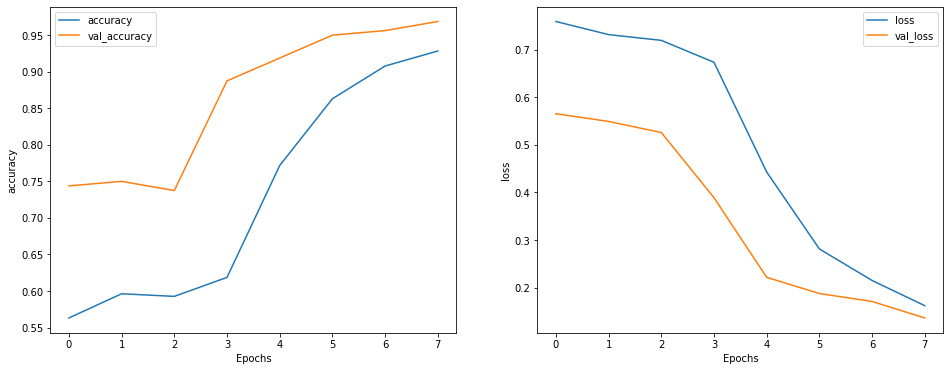

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Comparison of the accuracy of different types of activation functions



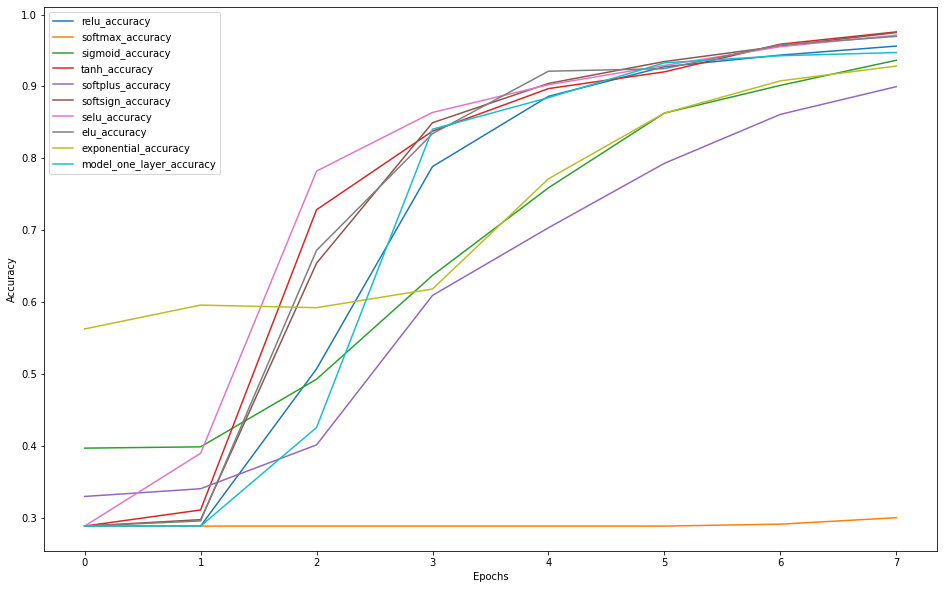

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(relu_accuracy);
plt.plot(softmax_accuracy);
plt.plot(sigmoid_accuracy);
plt.plot(tanh_accuracy);
plt.plot(softplus_accuracy);
plt.plot(softsign_accuracy);
plt.plot(selu_accuracy);
plt.plot(elu_accuracy);
plt.plot(exponential_accuracy);
plt.plot(model_one_layer_accuracy);
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["relu_accuracy", "softmax_accuracy", "sigmoid_accuracy", "tanh_accuracy","softplus_accuracy","softsign_accuracy","selu_accuracy","elu_accuracy","exponential_accuracy", "model_one_layer_accuracy"])

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], relu_accuracy, label='relu_accuracy')
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], softmax_accuracy, label='softmax_accuracy')
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], sigmoid_accuracy, label='sigmoid_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], tanh_accuracy, label='tanh_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], softplus_accuracy, label='softplus_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], softsign_accuracy, label='softsign_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], selu_accuracy, label='selu_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], elu_accuracy, label='elu_accuracy');
# plt.plot([0, 1, 2, 3, 4, 5, 6, 7], exponential_accuracy, label='exponential_accuracy');
# plt.legend()